# About

Alle Titel aus der Bibliografie von Leo Konle werden in die SRU-Katalogsuche der DNB gegeben. Dabei wird immer nach Titel und Verlag gesucht. Ausgewählte Daten der Ergebnisse werden als csv gespeichert. Die vorhandenen Umfangsangaben werden ausgewertet.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as soup
import unicodedata
from lxml import etree


# Marc-Doku
[Controlfield 007 Medientyp](https://www.loc.gov/marc/bibliographic/bd007c.html)


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/LeKonArD/heftroman-universum/master/plot_hefte_.csv', sep='\t')
df

,genre,title,start,end,publisher,count,Quelle
0,Abenteuer,AUS ALLEN TEILEN DER WELT,1899,1899,Münchmeyer,5,BDH
1,Abenteuer,AUS ALLEN WELTTEILEN,1899,1899,Münchmeyer,5,BDH
2,unklar,MODERNE ZEHNPFENNIG BIBLIOTHEK,1901,?,Klambt,246,BDH
3,Erotik,EIN BLICK DURCH'S SCHLÜSSELLOCH,1902,1903,Dresdner,48,BDH
4,unklar,GEHEIMNISVOLLE BIBLIOTHEK,1902,1906,Dresdner,160,BDH
...,...,...,...,...,...,...,...
705,unklar,TOM HYPNOS,?,?,Bison,12,BDH
706,Western,TRAPPER TREUHERZ,?,?,MVV,12,BDH
707,unklar,WAS MAN NICHT LAUT ERZÄHLT,?,?,Mitteldeutsche Verlagsanstalt,55,BDH
708,Western,WILD-WEST-BIBLIOTHEK,?,?,Eichler,25,BDH


In [53]:
df.publisher.unique().tolist()

['Münchmeyer',
 'Klambt',
 'Dresdner',
 'Berliner',
 'Eichler',
 'Zöphel',
 'Meteor',
 'Münchmeye',
 'Deutscher Volksliteraturverlag',
 'NVV',
 'VVK',
 'Lehmann',
 'Verlag Deutscher Volksliteratur',
 'Münchmeyer ',
 'DVV',
 'Weber',
 'VmL',
 'Segler',
 'Urban',
 'Neuer Verlag',
 'BBV',
 'Metropol',
 'Sect',
 'Mitteldeutsche Verlagsanstalt',
 'Dresdner Roman Verlag',
 'VmL ',
 'Gustav Müller',
 'Columbia Verlag',
 'Columbia',
 'Mignon',
 'Pinkert',
 'Vogel',
 'Wessel',
 'Heilbrunn',
 'Enßlin & Laiblins',
 'Nieerecker',
 'Verlag moderne Lektüre,',
 'Röttig',
 'Leipziger graphische Werke',
 'Müller & Königer',
 'Leipziger Graphische Werke',
 'Das Wissen dem Volke',
 'Monopol',
 'Blockhaus',
 'Zimmer',
 'Sonnenverlag',
 'Sonnen',
 'Rekord',
 'Diana',
 'Speka',
 'Ostra',
 ' Krömer',
 'Alster',
 'Dietsch',
 'Stern',
 'Universal',
 'Kleine',
 'Letsch',
 'Findeisen',
 'Richter',
 'Sternbücher',
 'Schlager',
 'Gnom',
 'Seybold',
 'Universal Verlag L. Walther',
 'Semrau',
 'Moderner Volksbüchere

In [3]:
def dnb_sru(titel, publisher):
    
    base_url = "https://services.dnb.de/sru/dnb"
    params = {'recordSchema' : 'MARC21-xml',
          'operation': 'searchRetrieve',
          'version': '1.1',
          'maximumRecords': '100',
          'query': f"tit = {titel} and vlg = {publisher}",
         }
    r = requests.get(base_url, params=params)
    xml = soup(r.content, features="xml")
    records = xml.find_all('record', {'type':'Bibliographic'})
    
    if len(records) < 100:
        # print(r.url)
        return records
    
    else:
        
        num_results = 100
        i = 101
        while num_results == 100:
            
            params.update({'startRecord': i})
            r = requests.get(base_url, params=params)
            xml = soup(r.content, features="xml")
            new_records = xml.find_all('record', {'type':'Bibliographic'})
            records+=new_records
            i+=100
            num_results = len(new_records)
            
        return records

In [4]:
def parse_record(record):
    
    ns = {"marc":"http://www.loc.gov/MARC21/slim"}
    xml = etree.fromstring(unicodedata.normalize("NFC", str(record)))
    
    #idn
    idn = xml.xpath("marc:controlfield[@tag = '001']", namespaces=ns)
    try:
        idn = idn[0].text
    except:
        idn = 'fail'

    # media_type
    media_type = xml.xpath("marc:controlfield[@tag = '007']", namespaces=ns)
    try:
        media_type = media_type[0].text
    except:
        media_type = 'fail'
    
    # Multipart resource record level
    multipart = xml.xpath("marc:leader", namespaces=ns)
    try:
        multipart = multipart[0].text[19]
    except:
        multipart = 'fail'
    
    # form
    form = xml.xpath("marc:datafield[@tag = '655']/marc:subfield[@code = 'a']", namespaces=ns)
    try:
        form = form[0].text
    except:
        form = ""
    
    # host
    host = xml.xpath("marc:datafield[@tag = '773']/marc:subfield[@code = 'a']", namespaces=ns)
    try:
        host = host[0].text
    except:
        host = ""

    # umfang
    umfang = xml.xpath("marc:datafield[@tag = '300']/marc:subfield[@code = 'a']", namespaces=ns)
    
    try:
        umfang = umfang[0].text
        #umfang = unicodedata.normalize("NFC", umfang)
    except:
        umfang = "unknown"

    # serien
    serie_titel = xml.xpath("marc:datafield[@tag = '830']/marc:subfield[@code = 'a']", namespaces=ns)
    serie_band = xml.xpath("marc:datafield[@tag = '830']/marc:subfield[@code = 'v']", namespaces=ns)
    serie_host = xml.xpath("marc:datafield[@tag = '830']/marc:subfield[@code = 'w']", namespaces=ns)

    try:
        serie_titel = serie_titel[0].text
    except:
        serie_titel = "unknown"

    try:
        serie_band = serie_band[0].text
    except:
        serie_band = "unknown"
    
    try:
        serie_host = serie_host[0].text
    except:
        serie_host = "unknown"
        
    # titel
    titel = xml.xpath("marc:datafield[@tag = '245']/marc:subfield[@code = 'a']", namespaces=ns)
    try:
        titel = titel[0].text
    except:
        titel = "unknown"
    
    # autor
    autor = xml.xpath("marc:datafield[@tag = '100']/marc:subfield[@code = 'a']", namespaces=ns)
    try:
        autor = autor[0].text
    except:
        autor = "unknown"

    # part_number
    part_number = xml.xpath("marc:datafield[@tag = '245']/marc:subfield[@code = 'n']", namespaces=ns)
    try:
        part_number = part_number[0].text
    except:
        part_number = "unknown"
    
    # part_titel
    part_titel = xml.xpath("marc:datafield[@tag = '245']/marc:subfield[@code = 'p']", namespaces=ns)
    try:
        part_titel = part_titel[0].text
    except:
        part_titel = "unknown"

    # jahr
    jahr = xml.xpath("marc:datafield[@tag = '264']/marc:subfield[@code = 'c']", namespaces=ns)
    try:
        jahr = jahr[0].text
    except:
        jahr = "unknown"
    
    # ereproduktion
    repro_type = xml.xpath("marc:datafield[@tag = '776']/marc:subfield[@code = 'i']", namespaces=ns)
    repro_idn = xml.xpath("marc:datafield[@tag = '776']/marc:subfield[@code = 'w']", namespaces=ns)

    try:
        repro_type = repro_type[0].text
    except:
        repro_type = "unknown"
    
    try:
        repro_idn = repro_idn[0].text
    except:
        repro_idn = "unknown"


    meta_dict = {"idn":idn, "media_type":media_type, "multipart_level":multipart, "form":form, "umfang":umfang, "serie_titel":serie_titel, "serie_band":serie_band, "serie_host":serie_host,"titel":titel, "autor":autor, "part_number":part_number, "part_titel":part_titel, "jahr":jahr, "repro_type":repro_type, "repro_idn":repro_idn}
    return meta_dict

In [5]:
def bandsuche(idn):
    
    base_url = "https://services.dnb.de/sru/dnb"
    params = {'recordSchema' : 'MARC21-xml',
          'operation': 'searchRetrieve',
          'version': '1.1',
          'maximumRecords': '100',
          'query': f"partof = {idn}",
         }
    r = requests.get(base_url, params=params)
    xml = soup(r.content, features="xml")
    records = xml.find_all('record', {'type':'Bibliographic'})
    
    if len(records) < 100:
        # print(r.url)
        return records
    
    else:
        
        num_results = 100
        i = 101
        while num_results == 100:
            
            params.update({'startRecord': i})
            r = requests.get(base_url, params=params)
            xml = soup(r.content, features="xml")
            new_records = xml.find_all('record', {'type':'Bibliographic'})
            records+=new_records
            i+=100
            num_results = len(new_records)
            
        return records

In [6]:
def verlagssuche(verlag):
        
    base_url = "https://services.dnb.de/sru/dnb"
    params = {'recordSchema' : 'MARC21-xml',
          'operation': 'searchRetrieve',
          'version': '1.1',
          'maximumRecords': '100',
          'query': f"vlg = {verlag}",
         }
    r = requests.get(base_url, params=params)
    xml = soup(r.content, features="xml")
    records = xml.find_all('record', {'type':'Bibliographic'})
    
    if len(records) < 100:
        # print(r.url)
        return records
    
    else:
        
        num_results = 100
        i = 101
        while num_results == 100:
            
            params.update({'startRecord': i})
            r = requests.get(base_url, params=params)
            xml = soup(r.content, features="xml")
            new_records = xml.find_all('record', {'type':'Bibliographic'})
            records+=new_records
            i+=100
            num_results = len(new_records)
            
        return records

In [5]:
df_all = pd.DataFrame()

for row in df.itertuples():
    records = dnb_sru(row.title, row.publisher)
    output = [parse_record(record) for record in records]
    df_all = pd.concat([df_all, pd.DataFrame(output)], ignore_index=True)

df_all


,idn,media_type,multipart_level,form,umfang,serie_titel,serie_band,serie_host,titel,autor,part_number,part_titel,jahr,repro_type,repro_idn
0,1236850289,cr||||||||||||,,Monografische Reihe,unkown,unkown,unkown,unkown,Moderne 10-Pfennig-Bibliothek,unkown,unkown,unkown,1912-1915,Elektronische Reproduktion von,(DE-600)2232259-0
1,979424100,tu,,Monografische Reihe,unkown,unkown,unkown,unkown,Moderne 10-Pfennig-Bibliothek,unkown,unkown,unkown,1905-1915,Elektronische Reproduktion,(DE-600)3076067-7
2,362945330,tu,,,62 S.,Geheimnisvolle Bibliothek,Bd. 2,unkown,Der schwarze Don Juan,"Vermont, H. de",unkown,unkown,1902,unkown,unkown
3,362059853,tu,,,63 S.,Geheimnisvolle Bibliothek,Bd. 11,unkown,"Die Cancantänzerin aus ""Moulin Rouge""","Pompé, Charlotte",unkown,unkown,[um 1902],unkown,unkown
4,578018888,tu,c,,62 S.,unkown,unkown,unkown,Geheimnisvolle Bibliothek,unkown,Bd. 1.,In verrufenem Hause / Jadwiga Grünberg,1902-,unkown,unkown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31868,1001871995,tu,c,,Je 16 S.,unkown,unkown,unkown,Schlumperfritz und Schlamperfranz,unkown,Streich 21-32,unkown,[1922],Online-Ausg.,(DE-101)1017669864
31869,560894082,tu,a,,unkown,unkown,unkown,unkown,Schlumperfritz und Schlamperfranz,unkown,unkown,unkown,unkown,Online-Ausg.,(DE-101)1017669856
31870,1017669856,cr||||||||||||,a,,unkown,unkown,unkown,unkown,Schlumperfritz und Schlamperfranz,unkown,unkown,unkown,unkown,Druckausg.,(DE-101)560894082
31871,580196917,tu,,,319 S.,Sonnen-Strahlen,[1],(DE-101)362764395,Im Zuchthause,"Hirschfeld, Max",unkown,unkown,[1920],unkown,unkown


In [17]:
# Die mit den monographischen Reihen verknüpften Monographien werden im df df_reihenhefte gespeichert
df_reihenhefte = pd.DataFrame()
for idn in df_all[(df_all['media_type'] == 'tu') & (df_all['repro_idn'] == 'unkown') & (df_all['form'] == 'Monografische Reihe')]['idn'].to_list():
    records = bandsuche(idn)
    output = [parse_record(record) for record in records]
    df_reihenhefte = pd.concat([df_reihenhefte, pd.DataFrame(output)], ignore_index=True)

df_reihenhefte

,idn,media_type,multipart_level,form,umfang,serie_titel,serie_band,serie_host,titel,autor,part_number,part_titel,jahr,repro_type,repro_idn
0,579846474,tu,,,96 S.,Bunte Sammlung interessanter Erzählungen,Bd. 116,(DE-101)362221782,Die Pußtagräfin,"Fogl, Mathilde",unkown,unkown,[1926],unkown,unkown
1,36308374X,tu,,,80 S.,Bunte Sammlung interessanter Erzählungen,Bd. 117,(DE-101)362221782,Dunkle Wege,"Wilken, A.",unkown,unkown,[1926],unkown,unkown
2,580157768,tu,,,79 S.,Bunte Sammlung interessanter Erzählungen,Bd. 120,(DE-101)362221782,Es lebe das Leben,"Henzel, Maria",unkown,unkown,[1926],unkown,unkown
3,57891137X,tu,,,96 S.,Bunte Sammlung interessanter Erzählungen,Bd. 118,(DE-101)362221782,Förster Maifelds Schuld,"Blümcke, Ludwig",unkown,unkown,[1926],unkown,unkown
4,578998904,tu,,,79 S.,Bunte Sammlung interessanter Erzählungen,Bd. 115,(DE-101)362221782,Majestät Ich,"Buhl, Curt",unkown,unkown,[1926],unkown,unkown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,362220972,tu,,,32 S.,Deutsche Taten,Bd. 14,(DE-101)362866058,Samariter,unkown,unkown,unkown,[um 1916],unkown,unkown
2200,362980012,tu,,,32 S.,Deutsche Taten,Bd. 13,(DE-101)362866058,Volldampf voraus,unkown,unkown,unkown,[um 1916],unkown,unkown
2201,363001840,tu,,,32 S.,Deutsche Taten,Bd. 30,(DE-101)362866058,Waldkämpfe,unkown,unkown,unkown,[um 1916],unkown,unkown
2202,363031480,tu,,,32 S.,Deutsche Taten,Bd. 20,(DE-101)362866058,Weihnachten im Felde,unkown,unkown,unkown,[um 1916],unkown,unkown


In [7]:
# df_integral = pd.concat([df_all, df_reihenhefte], ignore_index=True)
df_integral = pd.read_csv("integral.csv").set_index("idn").replace('unkown','unknown')
df_integral["umfang_norm"] = df_integral.umfang.str.extract(r"(\d+)\s+[sSeite.]+", expand=True)
df_integral


,media_type,multipart_level,form,umfang,serie_titel,serie_band,serie_host,titel,autor,part_number,part_titel,jahr,repro_type,repro_idn,umfang_norm
idn,,,,,,,,,,,,,,,
1236850289,cr||||||||||||,,Monografische Reihe,unknown,unknown,unknown,unknown,Moderne 10-Pfennig-Bibliothek,unknown,unknown,unknown,1912-1915,Elektronische Reproduktion von,(DE-600)2232259-0,NaN
979424100,tu,,Monografische Reihe,unknown,unknown,unknown,unknown,Moderne 10-Pfennig-Bibliothek,unknown,unknown,unknown,1905-1915,Elektronische Reproduktion,(DE-600)3076067-7,NaN
362945330,tu,,NaN,62 S.,Geheimnisvolle Bibliothek,Bd. 2,unknown,Der schwarze Don Juan,"Vermont, H. de",unknown,unknown,1902,unknown,unknown,62
362059853,tu,,NaN,63 S.,Geheimnisvolle Bibliothek,Bd. 11,unknown,"Die Cancantänzerin aus ""Moulin Rouge""","Pompé, Charlotte",unknown,unknown,[um 1902],unknown,unknown,63
578018888,tu,c,NaN,62 S.,unknown,unknown,unknown,Geheimnisvolle Bibliothek,unknown,Bd. 1.,In verrufenem Hause / Jadwiga Grünberg,1902-,unknown,unknown,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362220972,tu,,NaN,32 S.,Deutsche Taten,Bd. 14,(DE-101)362866058,Samariter,unknown,unknown,unknown,[um 1916],unknown,unknown,32
362980012,tu,,NaN,32 S.,Deutsche Taten,Bd. 13,(DE-101)362866058,Volldampf voraus,unknown,unknown,unknown,[um 1916],unknown,unknown,32
363001840,tu,,NaN,32 S.,Deutsche Taten,Bd. 30,(DE-101)362866058,Waldkämpfe,unknown,unknown,unknown,[um 1916],unknown,unknown,32


In [15]:
df_integral[(df_integral['media_type'] == 'tu') & (df_integral['repro_idn'] == 'unknown')].umfang_norm.dropna().astype(int).sum()

2154886

In [13]:
df_integral.sort_values("umfang_norm").dropna().tail()

,media_type,multipart_level,form,umfang,serie_titel,serie_band,serie_host,titel,autor,part_number,part_titel,jahr,repro_type,repro_idn,umfang_norm
idn,,,,,,,,,,,,,,,
363103767,tu,,Fiktionale Darstellung,96 S.,Der 30-Pfennig-Roman,Bd. 52,unknown,Wenn der Vater mit dem Sohne,"Wodehouse, Pelham G.",unknown,unknown,[1937],unknown,unknown,96
579019977,tu,,Autobiografie,96 S.,Seltsame Geschichten,Bd. 3,(DE-101)579947815,Die Flucht aus den Bleikammern,"Casanova, Giacomo Girolamo",unknown,unknown,1940,unknown,unknown,96
363103899,tu,,Fiktionale Darstellung,96 S.,Der 30-Pfennig-Roman,Bd. 96,unknown,Ein X für ein U,"Wodehouse, Pelham G.",unknown,unknown,[1938],unknown,unknown,96
1132584159,cr||||||||||||,,Erzählende Literatur: Gegenwartsliteratur ab 1945,"Online-Ressourcen, 98 Seiten",Caprice,61,unknown,Höhepunkte zur Geisterstunde - Caprice,"Blue, Jil",unknown,unknown,2017,unknown,unknown,98
951396552,tu,,Wörterbuch,992 S.,Bastei-Lübbe-Taschenbuch,Bd. 13899 : Allgemeine Reihe,(DE-101)010434747,John-Sinclair-Lexikon,"Delfs, Rainer",unknown,unknown,1997,unknown,unknown,992


In [26]:
df_integral.to_csv('integral.csv')

In [35]:
umfaenge = df_integral[(df_integral['media_type'] == 'tu') & (df_integral['repro_idn'] == 'unknown')].umfang.str.extract('(\d+)\s[sSeiten.]+')
umfaenge.rename(columns={0:'seiten'}, inplace=True)
umfaenge.to_csv('seitenzahlen.csv')


In [36]:
# Durchschnitt
umfaenge[umfaenge.seiten.notna()].seiten.astype(int).mean()


104.14809086515224

In [37]:
# Median
umfaenge[umfaenge.seiten.notna()].seiten.astype(int).sum()

2154824

In [33]:
df_integral[(df_integral['media_type'] == 'tu') & (df_integral['repro_idn'] == 'unknown') & (df_integral['form'] != 'Monografische Reihe')]

,media_type,multipart_level,form,umfang,serie_titel,serie_band,serie_host,titel,autor,part_number,part_titel,jahr,repro_type,repro_idn
idn,,,,,,,,,,,,,,
362945330,tu,,NaN,62 S.,Geheimnisvolle Bibliothek,Bd. 2,unknown,Der schwarze Don Juan,"Vermont, H. de",unknown,unknown,1902,unknown,unknown
362059853,tu,,NaN,63 S.,Geheimnisvolle Bibliothek,Bd. 11,unknown,"Die Cancantänzerin aus ""Moulin Rouge""","Pompé, Charlotte",unknown,unknown,[um 1902],unknown,unknown
578018888,tu,c,NaN,62 S.,unknown,unknown,unknown,Geheimnisvolle Bibliothek,unknown,Bd. 1.,In verrufenem Hause / Jadwiga Grünberg,1902-,unknown,unknown
57801890X,tu,c,NaN,63 S.,unknown,unknown,unknown,Geheimnisvolle Bibliothek,unknown,Bd. 11.,"Die Cancantänzerin aus ""Moulin Rouge"" / Char...",1902-,unknown,unknown
578018896,tu,c,NaN,62 S.,unknown,unknown,unknown,Geheimnisvolle Bibliothek,unknown,Bd. 2.,Der schwarze Don Juan / H. de Vermont,1902-,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362220972,tu,,NaN,32 S.,Deutsche Taten,Bd. 14,(DE-101)362866058,Samariter,unknown,unknown,unknown,[um 1916],unknown,unknown
362980012,tu,,NaN,32 S.,Deutsche Taten,Bd. 13,(DE-101)362866058,Volldampf voraus,unknown,unknown,unknown,[um 1916],unknown,unknown
363001840,tu,,NaN,32 S.,Deutsche Taten,Bd. 30,(DE-101)362866058,Waldkämpfe,unknown,unknown,unknown,[um 1916],unknown,unknown


<AxesSubplot:>

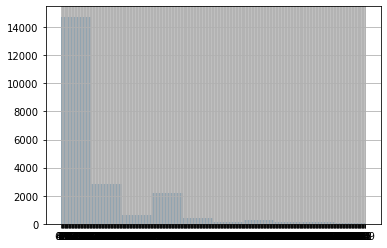

In [14]:
integral = pd.read_csv("integral.csv").set_index("idn")

integral.umfang_norm.hist()